## Evaluate Model

## Load trained model

In [18]:
import sys
# import the py file for loading the dataset
if "..\\121-layer\\src" not in sys.path:
    sys.path.insert(0,r'..\121-layer\src')
print(sys.path)

['..\\121-layer\\src', 'c:\\Users\\siyang\\Documents\\GitHub\\DeepLearningProject\\notebooks', 'C:\\Python312\\python312.zip', 'C:\\Python312\\DLLs', 'C:\\Python312\\Lib', 'C:\\Python312', 'c:\\Users\\siyang\\Documents\\GitHub\\DeepLearningProject\\.venv', '', 'c:\\Users\\siyang\\Documents\\GitHub\\DeepLearningProject\\.venv\\Lib\\site-packages', 'C:\\Users\\siyang\\Documents\\GitHub\\DeepLearningProject', 'c:\\Users\\siyang\\Documents\\GitHub\\DeepLearningProject\\.venv\\Lib\\site-packages\\win32', 'c:\\Users\\siyang\\Documents\\GitHub\\DeepLearningProject\\.venv\\Lib\\site-packages\\win32\\lib', 'c:\\Users\\siyang\\Documents\\GitHub\\DeepLearningProject\\.venv\\Lib\\site-packages\\Pythonwin']


In [19]:
import torch
torch.manual_seed(42)

from custom_densenet import *
from preprocessing import *
train_dataset, val_dataset,train_loader, val_loader,test_dataset, test_loader= get_data_loaders(data_dir='../raw_data/archive/', label_file='../raw_data/archive/CXR8-selected/Data_Entry_2017_v2020.csv')

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
pathModel = r"..\notebooks\dnet_models\m-custom_dnet_binary_by_img_count_lr_1e-4.pth.tar"
pathModel = r"..\notebooks\dnet_models\m-custom_dnet_binary_by_img_count_lr_1e-4_bs_16_3_non_img_data.pth.tar"

model = dense_net_v3(1, training=False)
modelCheckpoint = torch.load(pathModel)
model.load_state_dict(modelCheckpoint['state_dict'])
model.to(device)

dense_net_v3(
  (initial_setup): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (denseblock1): dense_block(
    (dense_layer0): dense_layer(
      (net): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
        (5): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
    )
    (dense_layer1): dense_layer(
      (net): Sequential(
        (0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

In [21]:
for i, block in enumerate(model.children()):
    print(i)
    if i < len(list(model.children())) - 1:
        print(block)
    

0
Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
)
1
dense_block(
  (dense_layer0): dense_layer(
    (net): Sequential(
      (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): ReLU(inplace=True)
      (5): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
  )
  (dense_layer1): dense_layer(
    (net): Sequential(
      (0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): ReLU(inplace=True)
      (2): Conv2d(96, 128, kernel_size=(1, 1), stride=(1

## Evaluate model on the test_dataset

In [36]:
CLASS_NAMES = ['Pneumothorax']
outGT = torch.FloatTensor().cuda()
outPRED = torch.FloatTensor().cuda()

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

tp = [0 for i in range(1,10)]
fp = [0 for i in range(1,10)]
fn = [0 for i in range(1,10)]

def f1_score(tp, fp, fn):
    return 2 * (tp) / (2 * tp + fp + fn)

model.eval()
fp_16 = []
fn_16 = []

for i, (input, target, non_img_data) in enumerate(test_loader):
    input = input.to(device)
    target = target.cuda()
    outGT = torch.cat((outGT, target), 0)
    
    ## NEW for v2
    non_img_data = non_img_data.to(device)
    ## NEW for v2 end

    

    with torch.no_grad():    
        # out = model(input)
        ## NEW for v2
        out = model((input,non_img_data))
        ## NEW for v2 end
        
        for j in range(1,10):
            pred_labels = (out > j/10).long().T.squeeze(0)
            tp[j-1] += sum(torch.logical_and(pred_labels, target))
            fp[j-1] += sum(torch.logical_and(torch.logical_xor(pred_labels, target).long(), pred_labels))
            fn[j-1] += sum(torch.logical_and(torch.logical_xor(pred_labels, target).long(), target))
            if j == 5:
                  if len(fp_16) < 16:
                        # print(len(input[torch.logical_and(torch.logical_xor(pred_labels, target).long(), pred_labels)]))
                        for image in input[torch.logical_and(torch.logical_xor(pred_labels, target).long(), pred_labels)]:
                            fp_16.append(image)
                  if len(fn_16) < 16:
                        for image in input[torch.logical_and(torch.logical_xor(pred_labels, target).long(), target)]:
                            fn_16.append(image)
        outPRED = torch.cat((out, out.data), 0)

for k in range(1,10):
            print(f"confidence threshold {k/10}")
            print("tp_sum: {:.4f}, fp_sum: {:.4f}, fn_sum: {:.4f}, cumulative_f1_score: {:.4f}".format(
                                                                     tp[k-1], \
                                                                     fp[k-1],\
                                                                     fn[k-1],\
                                                                     f1_score(tp[k-1], fp[k-1], fn[k-1])))
        
     
# aurocIndividual = computeAUROC(outGT, outPRED, nnClassCount)
# aurocMean = np.array(aurocIndividual).mean()

# print ('AUROC mean ', aurocMean)

# for i in range (0, len(aurocIndividual)):
#     print (CLASS_NAMES[i], ' ', aurocIndividual[i])


confidence threshold 0.1
tp_sum: 523.0000, fp_sum: 537.0000, fn_sum: 0.0000, cumulative_f1_score: 0.6608
confidence threshold 0.2
tp_sum: 522.0000, fp_sum: 535.0000, fn_sum: 1.0000, cumulative_f1_score: 0.6608
confidence threshold 0.3
tp_sum: 503.0000, fp_sum: 495.0000, fn_sum: 20.0000, cumulative_f1_score: 0.6614
confidence threshold 0.4
tp_sum: 439.0000, fp_sum: 388.0000, fn_sum: 84.0000, cumulative_f1_score: 0.6504
confidence threshold 0.5
tp_sum: 168.0000, fp_sum: 97.0000, fn_sum: 355.0000, cumulative_f1_score: 0.4264
confidence threshold 0.6
tp_sum: 21.0000, fp_sum: 23.0000, fn_sum: 502.0000, cumulative_f1_score: 0.0741
confidence threshold 0.7
tp_sum: 6.0000, fp_sum: 5.0000, fn_sum: 517.0000, cumulative_f1_score: 0.0225
confidence threshold 0.8
tp_sum: 1.0000, fp_sum: 2.0000, fn_sum: 522.0000, cumulative_f1_score: 0.0038
confidence threshold 0.9
tp_sum: 0.0000, fp_sum: 0.0000, fn_sum: 523.0000, cumulative_f1_score: 0.0000


lets look at the first sixteen false positives
2.535425
2.535425


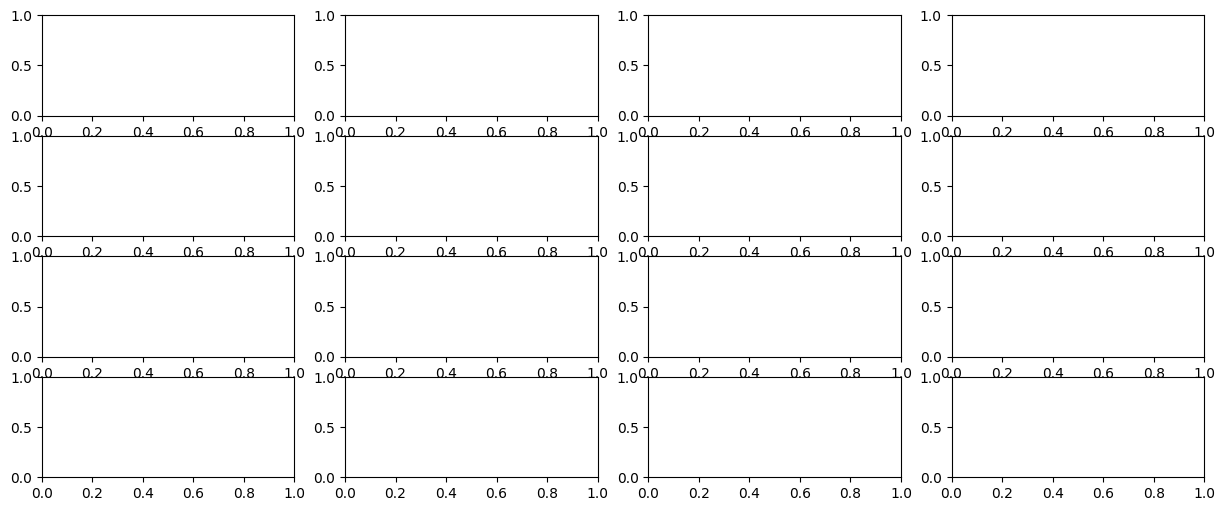

In [58]:
import torchvision
import matplotlib.pyplot as plt 
from PIL import Image
import numpy as np

print("lets look at the first sixteen false positives")
# for item in input:
#     trans = torchvision.transforms.ToPILImage()
#     out = trans(item)
#     plt.imshow(out)
#     break

num_rows = 4
num_cols = 4
# print(input.shape)
# Display each image
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 6))


for i, ax in enumerate(axes.flat):
    item = fp_16[i]
    # print(item.shape)
    img_np = item.cpu().numpy()
    img_np = np.transpose(img_np, (1,2,0))
    print(np.max(img_np))
    print(max(img_np.reshape(1,-1).squeeze()))
    break
    # ax.imshow((img_np * 255).astype(np.uint8))
    ax.imshow(img_np)
    ax.axis('off')  # Turn off axis labels


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

lets look at the first sixteen false negatives


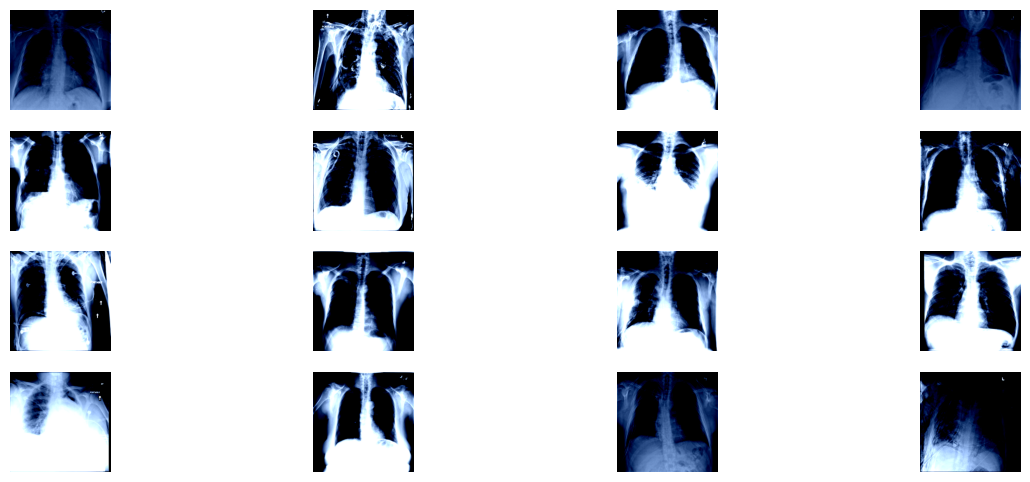

In [38]:
import torchvision
import matplotlib.pyplot as plt 
from PIL import Image
import numpy as np

print("lets look at the first sixteen false negatives")
# for item in input:
#     trans = torchvision.transforms.ToPILImage()
#     out = trans(item)
#     plt.imshow(out)
#     break

num_rows = 4
num_cols = 4
# print(input.shape)
# Display each image
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 6))


for i, ax in enumerate(axes.flat):
    item = fn_16[i]
    # print(item.shape)
    img_np = item.cpu().numpy()
    img_np = np.transpose(img_np, (1,2,0))
    ax.imshow(img_np)
    ax.axis('off')  # Turn off axis labels
